<hr>

# Project：SentencePiece NSMC

&nbsp;

이번 프로젝트는 예전에 사용해 봤던 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece 를 적용시켜 볼 것이다.

SentencePiece 를 적용시킨 모델을 학습시키고, 학습된 모델로 sp_tokenize() 메소드를 구현할 것이다.

구현된 토크나어지를 네이버 영화리뷰 감정 분석 코퍼스에 적용하여, 감정 분석 모델을 재학습 하여,

SentencePiece 와 여러가지 형태소 분석기를 사용한 모델들과의 성능 비교도 해 보겠다.

마지막으로 SentencePiece 모델의 파라메터를 변경해 보며 성능 개선 여부를 확인해보도록 하겠다.

바로 시작해 보자.

&nbsp;

## 0. 라이브러리 확인

In [1]:
from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
import konlpy
from konlpy.tag import Hannanum, Kkma, Komoran, Mecab, Okt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sentencepiece as spm
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

print(gensim.__version__)
print(konlpy.__version__)
print(np.__version__)
print(pd.__version__)
print(tf.__version__)

4.1.2
0.5.2
1.21.4
1.3.3
2.6.0


&nbsp;

## 1. 데이터 준비

#### ◾데이터 가져오기

In [2]:
import pandas as pd

# 데이터 불러오기
train_data = pd.read_table("~/aiffel/sp_tokenizer/ratings_train.txt")
test_data = pd.read_table("~/aiffel/sp_tokenizer/ratings_test.txt")

print("✔️")

✔️


In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.tail()

,id,document,label
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0
49999,6070594,마무리는 또 왜이래,0


#### ◾데이터 전처리

#### ▪️ 중복 데이터 삭제

In [5]:
## 중복값 확인 - Train

print("train_data 전체 :", train_data.shape)
print("train_data 중복 :", train_data[train_data["document"].duplicated()].shape)
print("train_data 중복제거후 예상 :", train_data[~train_data["document"].duplicated()].shape)

train_data 전체 : (150000, 3)
train_data 중복 : (3817, 3)
train_data 중복제거후 예상 : (146183, 3)


In [6]:
## 중복값 확인 - Test

print("test_data 전체 :", test_data.shape)
print("test_data 중복 :", test_data[test_data["document"].duplicated()].shape)
print("test_data 중복제거후 예상 :", test_data[~test_data["document"].duplicated()].shape)

test_data 전체 : (50000, 3)
test_data 중복 : (842, 3)
test_data 중복제거후 예상 : (49158, 3)


In [7]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=["document"], inplace=True)
test_data.drop_duplicates(subset=["document"], inplace=True)

In [8]:
## 결측값 확인 - Train

print("train_data 전체 :", train_data.shape)
print("train_data 결측 :", train_data[train_data['document'].isnull()].shape)
print("train_data 결측제거후 예상 :", train_data[~train_data['document'].isnull()].shape)

train_data 전체 : (146183, 3)
train_data 결측 : (1, 3)
train_data 결측제거후 예상 : (146182, 3)


In [9]:
## 결측값 확인 - Test

print("test_data 전체 :", test_data.shape)
print("test_data 결측 :", test_data[test_data['document'].isnull()].shape)
print("test_data 결측제거후 예상 :", test_data[~test_data['document'].isnull()].shape)

test_data 전체 : (49158, 3)
test_data 결측 : (1, 3)
test_data 결측제거후 예상 : (49157, 3)


In [10]:
# NaN 값이 존재하는 행 제거
train_data = train_data.dropna(how = "any") 
test_data = test_data.dropna(how = "any") 

#### ▪️ 결측값 재확인

In [11]:
pd.isnull(train_data).sum()

id          0
document    0
label       0
dtype: int64

In [12]:
pd.isnull(test_data).sum()

id          0
document    0
label       0
dtype: int64

#### ▪️ 불용어

In [13]:
stopwords = ["아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가", "으로", "로", "에게", "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면", "저", "소인", "소생", "저희", "지말고", "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다", "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고", "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에", "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다", "하는 편이 낫다", "불문하고", "향하여", "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에", "하여야", "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다", "이리하여", "그리하여", "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써", "까지", "해야한다", "일것이다", "반드시", "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등", "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서", "대하여", "대하면", "훨씬", "얼마나", "얼마만큼", "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마", "지만", "하물며", "또한", "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면", "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다", "보드득", "비걱거리다", "꽈당", "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기", "하도록하다", "와", "과", "그러므로", "그래서", "고로", "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여", "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다", "하곤하였다", "하", "하하", "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳", "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉", "헐떡헐떡", "영차", "여차", "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩", "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면", "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는", "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도", "지든지", "몇", "거의", "하마터면", "인젠", "이젠", "된바에야", "된이상", "만큼	어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아", "고려하면", "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서", "이어서", "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고", "얼마든지", "마음대로", "주저하지 않고", "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래", "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", "말하자면", "시작하여", "시초에", "이상", "허", "헉", "허걱", "바와같이", "해도좋다", "해도된다", "게다가", "더구나", "하물며", "와르르", "팍", "퍽", "펄렁", "동안", "이래", "하고있었다", "이었다", "에서", "로부터", "까지", "예하면", "했어요", "해요", "함께", "같이", "더불어", "마저", "마저도", "양자", "모두", "습니다", "가까스로", "하려고하다", "즈음하여", "다른", "다른 방면으로", "해봐요", "습니까", "했어요", "말할것도 없고", "무릎쓰고", "개의치않고", "하는것만 못하다", "하는것이 낫다", "매", "매번", "들", "모", "어느것", "어느", "로써", "갖고말하자면", "어디", "어느쪽", "어느것", "어느해", "어느 년도", "라 해도", "언젠가", "어떤것", "어느것", "저기", "저쪽", "저것", "그때", "그럼", "그러면", "요만한걸", "그래", "그때", "저것만큼", "그저", "이르기까지", "할 줄 안다", "할 힘이 있다", "너", "너희", "당신", "어찌", "설마", "차라리", "할지언정", "할지라도", "할망정", "할지언정", "구토하다", "게우다", "토하다", "메쓰겁다", "옆사람", "퉤", "쳇", "의거하여", "근거하여", "의해", "따라", "힘입어", "그", "다음", "버금", "두번째로", "기타", "첫번째로", "나머지는", "그중에서", "견지에서", "형식으로 쓰여", "입장에서", "위해서", "단지", "의해되다", "하도록시키다", "뿐만아니라", "반대로", "전후", "전자", "앞의것", "잠시", "잠깐", "하면서", "그렇지만", "다음에", "그러한즉", "그런즉", "남들", "아무거나", "어찌하든지", "같다", "비슷하다", "예컨대", "이럴정도로", "어떻게", "만약", "만일", "위에서 서술한바와같이", "인 듯하다", "하지 않는다면", "만약에", "무엇", "무슨", "어느", "어떤", "아래윗", "조차", "한데", "그럼에도 불구하고", "여전히", "심지어", "까지도", "조차도", "하지 않도록", "않기 위하여", "때", "시각", "무렵", "시간", "동안", "어때", "어떠한", "하여금", "네", "예", "우선", "누구", "누가 알겠는가", "아무도", "줄은모른다", "줄은 몰랏다", "하는 김에", "겸사겸사", "하는바", "그런 까닭에", "한 이유는", "그러니", "그러니까", "때문에", "그", "너희", "그들", "너희들", "타인", "것", "것들", "너", "위하여", "공동으로", "동시에", "하기 위하여", "어찌하여", "무엇때문에", "붕붕", "윙윙", "나", "우리", "엉엉", "휘익", "윙윙", "오호", "아하", "어쨋든", "만 못하다	하기보다는", "차라리", "하는 편이 낫다", "흐흐", "놀라다", "상대적으로 말하자면", "마치", "아니라면", "쉿", "그렇지 않으면", "그렇지 않다면", "안 그러면", "아니었다면", "하든지", "아니면", "이라면", "좋아", "알았어", "하는것도", "그만이다", "어쩔수 없다", "하나", "일", "일반적으로", "일단", "한켠으로는", "오자마자", "이렇게되면", "이와같다면", "전부", "한마디", "한항목", "근거로", "하기에", "아울러", "하지 않도록", "않기 위해서", "이르기까지", "이 되다", "로 인하여", "까닭으로", "이유만으로", "이로 인하여", "그래서", "이 때문에", "그러므로", "그런 까닭에", "알 수 있다", "결론을 낼 수 있다", "으로 인하여", "있다", "어떤것", "관계가 있다", "관련이 있다", "연관되다", "어떤것들", "에 대해", "이리하여", "그리하여", "여부", "하기보다는", "하느니", "하면 할수록", "운운", "이러이러하다", "하구나", "하도다", "다시말하면", "다음으로", "에 있다", "에 달려 있다", "우리", "우리들", "오히려", "하기는한데", "어떻게", "어떻해", "어찌됏어", "어때", "어째서", "본대로", "자", "이", "이쪽", "여기", "이것", "이번", "이렇게말하자면", "이런", "이러한", "이와 같은", "요만큼", "요만한 것", "얼마 안 되는 것", "이만큼", "이 정도의", "이렇게 많은 것", "이와 같다", "이때", "이렇구나", "것과 같이", "끼익", "삐걱", "따위", "와 같은 사람들", "부류의 사람들", "왜냐하면", "중의하나", "오직", "오로지", "에 한하다", "하기만 하면", "도착하다", "까지 미치다", "도달하다", "정도에 이르다", "할 지경이다", "결과에 이르다", "관해서는", "여러분", "하고 있다", "한 후", "혼자", "자기", "자기집", "자신", "우에 종합한것과같이", "총적으로 보면", "총적으로 말하면", "총적으로", "대로 하다", "으로서", "참", "그만이다", "할 따름이다", "쿵", "탕탕", "쾅쾅", "둥둥", "봐", "봐라", "아이야", "아니", "와아", "응", "아이", "참나", "년", "월", "일", "령", "영", "일", "이", "삼", "사", "오", "육", "륙", "칠", "팔", "구", "이천육", "이천칠", "이천팔", "이천구", "하나", "둘", "셋", "넷", "다섯", "여섯", "일곱", "여덟", "아홉", "령", "영"]

#### ▪️ 텍스트 전처리 함수 작성

konlpy 방식을 사용하던 처리와 구분하여, 전처리 함수를 새로 정의하였다.

hangul_pre_proc_old, hangul_pre_proc_new 함수의 차이는, 공백문자 유지여부가 다르다.

In [14]:
## 간단하게 텍스트 전처리…
def hangul_pre_proc_old(content):
    content = content.strip()    ## strip() : 인자는 제거할 문자 지정. 지정 하지 않은 기본값은 문자열의 선행 후행 공백 제거
    content = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣\s]", "", content)    ## 한글과 공백을 제외하고 모두 제거
    content = content.strip()
    content = re.sub(r"[' ']+", " ", content) ## 1칸 초과하는 공백 제거 (첫번째 공백은 유지, 이어서 두번째 부터 공백 나타나면 제거)
    content = content.strip()
    return content

def hangul_pre_proc_new(content):
    content = content.strip()    ## strip() : 인자는 제거할 문자 지정. 지정 하지 않은 기본값은 문자열의 선행 후행 공백 제거
    content = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣]", "", content)    ## 한글과 공백을 제외하고 모두 제거
    content = content.strip()
    content = content.strip()
    return content

전처리 함수 테스트

In [15]:
print(hangul_pre_proc_old("아@!? 더빙......진짜       짜증나네요 목소리"))
print(hangul_pre_proc_new("아@!? 더빙......진짜       짜증나네요 목소리"))

아 더빙진짜 짜증나네요 목소리
아더빙진짜짜증나네요목소리


#### ▪️ 데이터 사본 생성

전처리에 쓰이는 함수의 구분에 따라 사용할 데이터프레임을 따로 분리하겠다.

In [16]:
## 정규표현식을 사용하려면 object 타입이 아니라 str 타입이어야 한다.
train_data["document"] = train_data["document"].apply(str)
test_data["document"] = test_data["document"].apply(str)

In [17]:
## Konlpy 에서 사용
train_data_ko = train_data.copy()
test_data_ko = test_data.copy()

## SentencePiece 에서 사용
train_data_sp = train_data.copy()
test_data_sp = test_data.copy()

#### ▪️ 전처리 함수 맵핑

In [18]:
## 간단한 전처리 － 내용에서 우리말 글자만 남기고 나머지 삭제
train_data_ko["document"] = train_data_ko["document"].map(lambda x: hangul_pre_proc_old(x))
test_data_ko["document"] = test_data_ko["document"].map(lambda x: hangul_pre_proc_old(x))
train_data_sp["document"] = train_data_sp["document"].map(lambda x: hangul_pre_proc_new(x))
test_data_sp["document"] = test_data_sp["document"].map(lambda x: hangul_pre_proc_new(x))

In [19]:
print("train_data_ko 전체 :", train_data_ko.shape)
print("test_data_ko 전체 :", test_data_ko.shape)
print("train_data_sp 전체 :", train_data_sp.shape)
print("test_data_sp 전체 :", test_data_sp.shape)

train_data_ko 전체 : (146182, 3)
test_data_ko 전체 : (49157, 3)
train_data_sp 전체 : (146182, 3)
test_data_sp 전체 : (49157, 3)


In [20]:
## 전처리 과정에서 내용이 사라진 행들이 있을 수 있다.
## 이것들을 nan 으로 변경하여 결측값으로 만들고, 결측값 확인을 다시 수행
train_data_ko["document"].replace("", np.nan, inplace=True)
test_data_ko["document"].replace("", np.nan, inplace=True)
train_data_sp["document"].replace("", np.nan, inplace=True)
test_data_sp["document"].replace("", np.nan, inplace=True)
print(train_data_ko.isnull().sum())
print(test_data_ko.isnull().sum())
print(train_data_sp.isnull().sum())
print(test_data_sp.isnull().sum())

id            0
document    789
label         0
dtype: int64
id            0
document    305
label         0
dtype: int64
id            0
document    789
label         0
dtype: int64
id            0
document    305
label         0
dtype: int64


In [21]:
# Null 값이 존재하는 행 제거
train_data_ko = train_data_ko.dropna(how = "any") 
test_data_ko = test_data_ko.dropna(how = "any") 
train_data_sp = train_data_sp.dropna(how = "any") 
test_data_sp = test_data_sp.dropna(how = "any") 

In [22]:
print(train_data_ko.isnull().sum())
print(test_data_ko.isnull().sum())
print(train_data_sp.isnull().sum())
print(test_data_sp.isnull().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


#### ▪️ 전처리 결과 확인

In [23]:
print("train_data_ko 전체 :", train_data_ko.shape)
print("test_data_ko 전체 :", test_data_ko.shape)
print("train_data_sp 전체 :", train_data_sp.shape)
print("test_data_sp 전체 :", test_data_sp.shape)

train_data_ko 전체 : (145393, 3)
test_data_ko 전체 : (48852, 3)
train_data_sp 전체 : (145393, 3)
test_data_sp 전체 : (48852, 3)


train 15만건, test 5만건 의 자료가 살짝 줄어들었다.

ko 로 끝나는 변수명의 데이터는 koNLPy 에서 사용할 데이터이고,

sp 로 끝나는 변수명의 데이터는 sentencepiece 에서 사용할 데이터이다.

두 데이터의 차이는 공백 유무이다. 아래에서 간략하게 확인해 보자.

In [24]:
train_data_ko.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [25]:
train_data_sp.head()

,id,document,label
0,9976970,아더빙진짜짜증나네요목소리,0
1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,6483659,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...,1


&nbsp;

### 2. Tokenize

토큰화에 사용할 형태소 분석기(morphological analyzer) 들을 정리하겠다.

KoNLPy 의 공식문서에서 패키지에 포함되는 형태소 분석기를 확인할 수 있다.

공식문서의 버전은, 현재 런타임 라이브러리 0.5.2 를 기준으로 가져왔다.

 - [KoNLPy - tag Package](https://konlpy.org/en/v0.5.2/api/konlpy.tag/)
 

#### ◾샘플 길이를 조정

문장의 길이를 확인하여, 지나치게 긴 데이터를 삭제하거나 지나치게 짧은 데이터를 검증 한다.

이를 통해 데이터를 얼마나 사용할지 타협점을 정의할 수 있다.

문장의 길이를 확인하는 함수를 만들도록 하겠다.

In [26]:
min_len = 9999
max_len = 0
sum_len = 0

def sentence_dist(sents, min_len=999, max_len=0, sum_len=0):

    for sen in sents:
        length = len(sen)
        if min_len > length: 
            min_len = length
        if max_len < length: 
            max_len = length
        sum_len += length

    print("문장의 최단 길이 :", min_len)
    print("문장의 최장 길이 :", max_len)
    print("문장의 평균 길이 :", sum_len // len(sents))

    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in sents:
        sentence_length[len(sen)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()

문장의 최단 길이 : 1
문장의 최장 길이 : 140
문장의 평균 길이 : 33


/tmp/ipykernel_2534/798530388.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


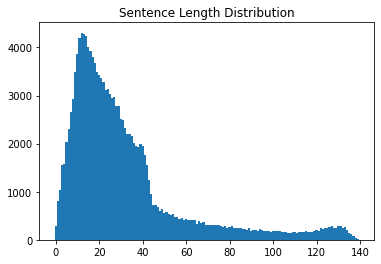

문장의 최단 길이 : 1
문장의 최장 길이 : 140
문장의 평균 길이 : 32


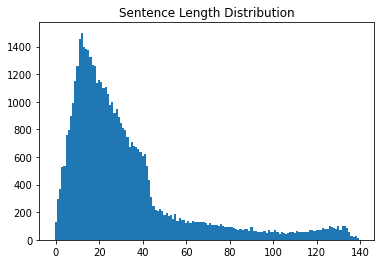

In [27]:
sentence_dist(train_data_ko["document"])
sentence_dist(test_data_ko["document"])

최단 길이는 1, 최장 길이는 140 인것을 확인할 수 있다. 

아래의 함수는 길이에 해당하는 문장을 확인하기 위한 함수이다.

In [28]:
## 매개변수：sents=문장, length길이, limit=최대 출력 갯수
def check_sentence_with_length(sents, length, limit=10):
    count = 0
    for sen in sents:
        if len(sen) == length:
            print(sen)
            print("─" * 64)
            count += 1
            if count > limit:
                return

길이가 1인 문장을 확인해보자.

In [29]:
check_sentence_with_length(train_data_ko["document"], 1)

아
────────────────────────────────────────────────────────────────
점
────────────────────────────────────────────────────────────────
잼
────────────────────────────────────────────────────────────────
즐
────────────────────────────────────────────────────────────────
끙
────────────────────────────────────────────────────────────────
와
────────────────────────────────────────────────────────────────
굿
────────────────────────────────────────────────────────────────
굿
────────────────────────────────────────────────────────────────
기
────────────────────────────────────────────────────────────────
짱
────────────────────────────────────────────────────────────────
휴
────────────────────────────────────────────────────────────────


길이가 최장길이인 문장을 확인해보자.

In [30]:
check_sentence_with_length(train_data_ko["document"], 140)

티비에서 해준거보고 빡쳐서 들어와서 쓴다 주인공커플 하는일 하나두없음 쫓기며 돌아다니기만하고 싸움중인 군인 불러대면서 구해달라 난리치고 주인공답게 뭐 하는것없어 답답해 죽겠는데 쓸데없이 화면은 느리게잡고 마지막엔 아오뽁쳐 엔딩화면뜨는데 온가족이 말잃음
────────────────────────────────────────────────────────────────
나는 나쁘지 않게 봤다만 대부분의사람들은 뭔가 있어보이면 명작이라고 칭송한단 말이지 니들이 이해못해서 재미없다고 하는 정신승리를 곁들여 말이야 연출은 참신했으나 복선이 진부하고 각 플롯마다 연관성이 부족했다 뭐 이것도 감독이 설계했다하면 할말 없겠지만
────────────────────────────────────────────────────────────────
이런컨셉이면 최소한 현실성에 기반을 두는데 이건 공상을 넘어선 허상 킬링탐용도 안됨 잠이안와서 뭔가 하나라도 스킵 해가면서 보려느 목적이라도 이건 보지마소 짜증나서 잠이 깰듯 내가 이거 호주에서 봤는데 이거 다 욕했음 밑엣놈은 그저 한국까는 한국쓰레기
────────────────────────────────────────────────────────────────
다율엄마 같은 착한병 환자는 암이나 치매 같은 병 같이 국가에서 관리해야 합니다 특히 다율엄마의 착한병은 다율엄마 본인 뿐만 아니라 가족과 이웃의 삶을 파탄시키는 아주 큰 질병 입니다 다율 엄마 같은 착한병 환자들을 국가에서 집중관리 당장 해야 합니다
────────────────────────────────────────────────────────────────
소방관과 의사이야기라서 그런가 사람 목숨가지고 관객들 감동시키는 너무 극적인 에피소드들이 과하게 많이 나열되어있고 한 부부 인생 망쳐놓고서 고수만 졸졸따라다니며 꼬시려는 한효주캐릭터는 너무 비현실적이며 별로였다 차라리 김성오랑 쥬니 커플이 훨씬 좋았다
───────────────────────────────────

모든 데이터를 다 사용하는 것은 연산 측면에서 비효율적이다.

가장 긴 데이터를 기준으로 패딩처리를 해야 하므로, 길이를 적당히 조절 해 줄 필요가 있다.

또한 너무 짧은 데이터는 오히려 노이즈로 작용할 수 있으니 제외하는 것도 도움이 될 수 있다.

여기서는 길이를 5 미만의 데이터를 제거하고, 길이 45 이상의 데이터도 제거하도록 하겠다.

In [31]:
max_len = 45
min_len = 5

In [32]:
# 길이 조건에 맞는 문장만 선택
train_data_ko = train_data_ko.loc[train_data_ko['document'].apply(lambda x: (min_len < len(x) <= max_len))]
test_data_ko = test_data_ko.loc[test_data_ko['document'].apply(lambda x: (min_len < len(x) <= max_len))]

분포를 다시 확인해보자.

문장의 최단 길이 : 6
문장의 최장 길이 : 45
문장의 평균 길이 : 22


/tmp/ipykernel_2534/798530388.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


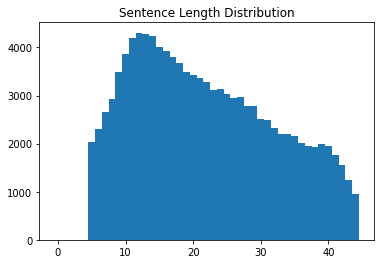

문장의 최단 길이 : 6
문장의 최장 길이 : 45
문장의 평균 길이 : 22


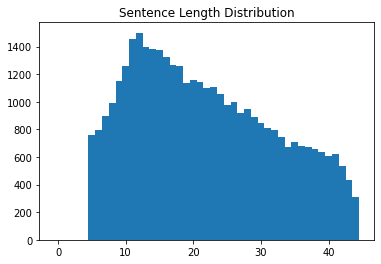

In [33]:
sentence_dist(train_data_ko["document"])
sentence_dist(test_data_ko["document"])

지금 생각해보니 sentencepiece 에 사용할 데이터를 진작 만들어 둘 필요가 없었던 것 같다.

지금의 데이터를 기준으로 다시 sentencepiece 에서 사용할 데이터를 만들도록 하겠다.

이전과 마찬가지로 공백 제거를 해 주도록 하겠다.

In [34]:
## 전처리(정규표현식, 중복 및 결측 제거)와 문장 길이 조정을 마친 train_data_ko 를 기준으로 사본을 만든다.
train_data_sp = train_data_ko.copy()
test_data_sp = test_data_ko.copy()

## sentencepiece 에서 사용할 데이터프레임을 만든다. (공백 유무의 차이가 있다.)
train_data_sp["document"] = train_data_sp["document"].map(lambda x: hangul_pre_proc_new(x))
test_data_sp["document"] = test_data_sp["document"].map(lambda x: hangul_pre_proc_new(x))

In [35]:
## 동일한 데이터인지 확인. (공백유무의 차이는 있음)
print("train_data_ko.shape :", train_data_ko.shape)
print("test_data_ko.shape :", test_data_ko.shape)
print("train_data_sp.shape :", train_data_sp.shape)
print("test_data_sp.shape :", test_data_sp.shape)

train_data_ko.shape : (113255, 3)
test_data_ko.shape : (37986, 3)
train_data_sp.shape : (113255, 3)
test_data_sp.shape : (37986, 3)


살짝 데이터 샘플을 확인 해 보자.

별다르게 볼 건 없고 공백 유무만 확인하고 넘어가도록 하겠다.

In [36]:
test_data_ko.sample(5)

,id,document,label
46039,6158045,보는내내 눈한번 떼지 않고 봤습니다 실화라 더 감동적이고 정말 멋졌습니다최고,1
7746,8515825,무슨 영화길래 평점이 운지수준이냐,0
35328,9879581,대단하다대단합니다,1
214,8725527,이렇게 불쾌한 내용을 왜 보게한거냐,0
38704,139252,기대에 못미치는 영화,0


In [37]:
test_data_sp.sample(5)

,id,document,label
31481,9983602,키쿠치린코연기력진짜어마어마하네요발연기로헐리웃진출할수있다는게놀라움,0
540,5278350,스토리가스릴있고훈훈하다,1
35275,10095969,너무재밋게봣네요ㅡ역시테이큰,1
46772,6894268,진짜재미없음,0
22988,8596611,편도재밌지만편이더재밌네요여주인공니사너무예뻐요ㅎㅎ,1


#### ◾ 형태소 분석기

형태소 분석기를 사용하여 토큰화를 하기 위한 준비를 한다.

아… 중요한 사태이다. 띄어쓰기 허용한 데이터셋과 제거한 데이터셋을 구분 할 필요가 없었다.

학습 부분참고하려고 보니, 지금까지 굳이 데이터셋을 나눌 필요가 없었다.

Exploration Node.08 의 로직을 따라야 할 것이라고 생각했는데, 지금 진행하면서 생각하니 아닌 것 같다.

아무렴. 일단 진행해 보도록 하겠다.

In [38]:
# from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt

hannanum = Hannanum()
kkma = Kkma()
komoran = Komoran()
mecab = Mecab()
okt = Okt() 

In [39]:
# def load_data_ko(tokenizer, train_data, test_data, num_words=10000):
#     # id 는 필요가 없으니 drop 한다.
#     train_data = train_data.drop(labels="id", axis=1)
#     test_data = test_data.drop(labels="id", axis=1)

#     # drop_duplicates메서드는 내용이 중복되는 행을 제거하는 메서드입니다.
#     train_data.drop_duplicates(subset=["document"], inplace=True)
#     test_data.drop_duplicates(subset=["document"], inplace=True)
    
#     ## 결측치 (NaN) 제거
#     train_data = train_data.dropna(how = "any") 
#     test_data = test_data.dropna(how = "any") 
    
#     ## 한국어 토크나이저로 토큰화
#     ## 불용어(Stopwords) 제거
#     X_train = []
#     print(tokenizer.__class__.__name__, "X_train：")
#     for sentence in tqdm(train_data["document"]):
#         temp_X = tokenizer.morphs(sentence) # 토큰화
#         temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
#         X_train.append(temp_X)
#     X_test = []
#     print(tokenizer.__class__.__name__, "X_test：")
#     for sentence in tqdm(test_data["document"]):
#         temp_X = tokenizer.morphs(sentence) # 토큰화
#         temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
#         X_test.append(temp_X)
    
#     ## 사전word_to_index 구성
#     words = np.concatenate(X_train).tolist()
#     counter = Counter(words)
#     counter = counter.most_common(10000-4)
#     vocab = ["<PAD>", "<BOS>", "<UNK>", "<UNUSED>"] + [key for key, _ in counter]
#     word_to_index = {word:index for index, word in enumerate(vocab)}
    
#     ## 텍스트 스트링을 사전 인덱스 스트링으로 변환 하는 함수
#     def wordlist_to_indexlist(wordlist):
#         return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]
    
#     ## 텍스트 스트링을 사전 인덱스 스트링으로 변환
#     X_train = list(map(wordlist_to_indexlist, X_train))
#     X_test = list(map(wordlist_to_indexlist, X_test))
    
#     ## X_train, y_train, X_test, y_test, word_to_index 리턴
#     return (X_train, np.array(list(train_data["label"])), X_test, np.array(list(test_data["label"]))), word_to_index

In [40]:
# ## Hannanum
# hnn_tt_pack, hnn_word_to_index = load_data_ko(hannanum, train_data_ko, test_data_ko)

# ## Kkma
# kkm_tt_pack, kkm_word_to_index = load_data_ko(kkma, train_data_ko, test_data_ko)

# ## Komoran
# kmr_tt_pack, kmr_word_to_index = load_data_ko(komoran, train_data_ko, test_data_ko)

# ## Mecab
# mec_tt_pack, mec_word_to_index = load_data_ko(mecab, train_data_ko, test_data_ko)

# ## Okt
# okt_tt_pack, okt_word_to_index = load_data_ko(okt, train_data_ko, test_data_ko)


위에서 사용했던 방법(예전 Exploration node 에서 사용)은 정상적으로 진행되지 않아서 사용할 수가 없다.

Kkma() 에서 java.lang.OutOfMemoryError: Java heap space 라는 문제가 지속적으로 발생한다. 원인은 알 수 없었다.

In [41]:
def morphs_data(tokenizer, train_data, test_data):
    
    X_train = []
    print(tokenizer.__class__.__name__, "X_train：")
    for sent in tqdm(train_data["document"]):
        words = tokenizer.morphs(sent)
        X_train.append(words)
    
    X_test = []
    print(tokenizer.__class__.__name__, "X_test：")
    for sent in tqdm(test_data["document"]):
        words = tokenizer.morphs(sent)
        X_test.append(words)
        
    
    ## X_train, y_train, X_test, y_test, word_to_index 리턴
    return (X_train, np.array(list(train_data["label"])), X_test, np.array(list(test_data["label"])))

In [42]:
## Hannanum
hnn_tt_pack = morphs_data(hannanum, train_data_ko, test_data_ko)

Hannanum X_train：


 68%|██████▊   | 76558/113255 [02:29<01:01, 598.53it/s]java.lang.ArrayIndexOutOfBoundsException: Index 10000 out of bounds for length 10000
	at kr.ac.kaist.swrc.jhannanum.plugin.MajorPlugin.PosTagger.HmmPosTagger.HMMTagger.new_mnode(HMMTagger.java:354)
	at kr.ac.kaist.swrc.jhannanum.plugin.MajorPlugin.PosTagger.HmmPosTagger.HMMTagger.tagPOS(HMMTagger.java:143)
	at kr.ac.kaist.swrc.jhannanum.hannanum.Workflow.analyzeInSingleThread(Workflow.java:857)
	at kr.ac.kaist.swrc.jhannanum.hannanum.Workflow.analyze(Workflow.java:521)
	at kr.lucypark.jhannanum.comm.HannanumInterface.simplePos09(Unknown Source)
100%|██████████| 113255/113255 [03:45<00:00, 502.41it/s]


Hannanum X_test：


100%|██████████| 37986/37986 [01:14<00:00, 506.99it/s]


In [43]:
# ## Kkma
# kkm_tt_pack = morphs_data(kkma, train_data_ko, test_data_ko)

In [44]:
## Komoran
kmr_tt_pack = morphs_data(komoran, train_data_ko, test_data_ko)

Komoran X_train：


100%|██████████| 113255/113255 [00:48<00:00, 2338.46it/s]


Komoran X_test：


100%|██████████| 37986/37986 [00:16<00:00, 2292.00it/s]


In [45]:
## Mecab
mec_tt_pack = morphs_data(mecab, train_data_ko, test_data_ko)

Mecab X_train：


100%|██████████| 113255/113255 [00:06<00:00, 17782.18it/s]


Mecab X_test：


100%|██████████| 37986/37986 [00:02<00:00, 17983.29it/s]


In [46]:
## Okt
okt_tt_pack = morphs_data(okt, train_data_ko, test_data_ko)

Okt X_train：


100%|██████████| 113255/113255 [05:55<00:00, 318.95it/s]


Okt X_test：


100%|██████████| 37986/37986 [02:00<00:00, 315.71it/s]


#### ◾ 단어 사전, Tensor 데이터

형태소분석을 거치고 토큰화된 데이터에서 단어사전과 Tensor 데이터를 만든다.

In [47]:
pad_seq="pre"
vocab_size=8000

In [48]:
def token_data(ttpack, vocab_size=15000, pad_seq="pre"):
    
    ## Unpacking
    tX_train, ty_train, tX_test, ty_test = ttpack
    tx_data = np.concatenate(tX_train + tX_test)

    ## Encoding
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(tx_data)
    tX_train = tokenizer.texts_to_sequences(tX_train)
    tX_test = tokenizer.texts_to_sequences(tX_test)
    
    # Padding
    tX_train = pad_sequences(tX_train, padding=pad_seq)
    tX_test = pad_sequences(tX_test, padding=pad_seq)
    
    return (tX_train, ty_train, tX_test, ty_test), tokenizer

In [49]:
## Mecab
mec_enc_pack, mec_tok = token_data(mec_tt_pack, vocab_size=vocab_size, pad_seq=pad_seq)

정수인코딩과 패딩이 잘 되었는지 확인해 보자.

In [50]:
def test_enc_data(encpack, tokenizer, idx=75):
    ## Unpacking
    tX_train, ty_train, tX_test, ty_test = encpack
    print(tX_test[idx])

    sentence = ""
    for w in tX_test[idx]:
        if w == 0: 
            continue
        sentence += tokenizer.index_word[w] + " "
    print (sentence)

In [51]:
test_enc_data(mec_enc_pack, mec_tok)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  701  190 2143   66]
단 두 마디 감동 


특별히 이상은 없는 것 같다.

다른 것들도 텐서로 인코딩을 하도록 하겠다.

In [52]:
## Hannanum
hnn_enc_pack, hnn_tok = token_data(hnn_tt_pack, vocab_size=vocab_size, pad_seq=pad_seq)

## Kkma 는 메모리 오류 발생하므로 사용하지 않겠다.
# ## Kkma
# kkm_enc_pack, kkm_tok = token_data(kkm_tt_pack, vocab_size=vocab_size, pad_seq=pad_seq)

## Komoran
kmr_enc_pack, kmr_tok = token_data(kmr_tt_pack, vocab_size=vocab_size, pad_seq=pad_seq)

## Okt
okt_enc_pack, okt_tok = token_data(okt_tt_pack, vocab_size=vocab_size, pad_seq=pad_seq)

#### ◾Sentence piece

공식 google 제품은 아니지만, google 이 공개한 SentencePiece 기술적 요약에 따르면 아래의 내용을 확인 할 수 있다.


- 여러 subword 알고리즘：BPE 알고리즘과 Unigram Language Model Tokenizer를 구현.


- 언어 독립적：SentencePiece는 문장을 유니코드 문자 시퀀스로 취급.
사전 토큰화 작업없이 단어 분리 토큰화를 수행하므로 언어에 종속되지 않음.


- 빠르고 가볍다：Segmentation 속도는 초당 약 50k 문장, 메모리 공간은 약 6MB.


&nbsp;

SentencePiece 모델에 대해서도 Tensor 데이터를 만들자.

#### ▪️ sentencepiece 모델 학습시키기

`tf.keras.preprocessing.text.Tokenizer`에 corpus를 주고 `tokenizer.fit_on_texts(corpus)`을 하면

토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 주기 위해서는,

SentencePiece 모델을 학습하는 과정을 거쳐야 한다.

In [53]:
## SentencePiece
# import sentencepiece as spm

## vocab_size 동일하게 적용
vocab_size = vocab_size
model_type="unigram"

def spm_train(train_corpus, test_corpus, vocab_size=15000, model_type="unigram"):

    ## 임시파일의 위치를 지정
    temp_file = os.getenv("HOME")+ "/aiffel/sp_tokenizer/data/nsmc_sp_" + model_type + ".train.ko.temp"

    with open(temp_file, "w") as f:
        print("[1／3]")
        for row in tqdm(train_corpus):   # 이전 스텝에서 정제했던 corpus를 활용합니다.
            f.write(str(row) + "\n")
        print("─" * 64)
        print("[2／3]")
        for row in tqdm(test_corpus):
            f.write(str(row) + "\n")
        print("─" * 64)
    
    print
    print("[3／3] SentencePieceTrainer.Train() Start")
    sp_model = spm.SentencePieceTrainer.Train(
        "--input={} --model_prefix=spm_{} --vocab_size={} --model_type={}" \
        .format(temp_file, model_type, vocab_size, model_type))
    #위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.
    print("SentencePieceTrainer.Train() End")
    print("─" * 64)

    return sp_model

In [54]:
spm_uni = spm_train(train_data_sp["document"], test_data_sp["document"], vocab_size=vocab_size, model_type=model_type)

[1／3]


100%|██████████| 113255/113255 [00:00<00:00, 1190642.56it/s]


────────────────────────────────────────────────────────────────
[2／3]


100%|██████████| 37986/37986 [00:00<00:00, 1235344.35it/s]

────────────────────────────────────────────────────────────────
[3／3] SentencePieceTrainer.Train() Start


SentencePieceTrainer.Train() End
────────────────────────────────────────────────────────────────


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/nsmc_sp_unigram.train.ko.temp --model_prefix=spm_unigram --vocab_size=8000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/nsmc_sp_unigram.train.ko.temp
  input_format: 
  model_prefix: spm_unigram
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vo

위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 --model_prefix 의 지정 값을 따라

spm_[모델타입].model 파일과 spm_[모델타입].vocab vocabulary 파일이 생성되었음을 확인할 수 있다.

In [55]:
!ls -l *spm*

-rw-r--r-- 1 root root 516373 Nov 21 09:18 korean_spm.model
-rw-r--r-- 1 root root 291993 Nov 21 09:18 korean_spm.vocab
-rw-r--r-- 1 root root 837197 Nov 21 13:37 spm_bpe.model
-rw-r--r-- 1 root root 556410 Nov 21 13:37 spm_bpe.vocab
-rw-r--r-- 1 root root 374622 Nov 22 01:29 spm_unigram.model
-rw-r--r-- 1 root root 144065 Nov 22 01:29 spm_unigram.vocab


이 모델을 활용하는 방법은 아래와 같다.

In [56]:
## 모델 불러오기
spp_uni = spm.SentencePieceProcessor()
spp_uni.Load("spm_" + model_type + ".model")

True

In [57]:
# SentencePiece를 활용한 sentence -> encoding
tokensIDs = spp_uni.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(spp_uni.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(spp_uni.DecodeIds(tokensIDs))

[3, 1083, 7, 302, 14, 2971, 101, 5, 0]
['▁', '아버지', '가', '방', '에', '들어가', '신', '다', '.']
아버지가방에들어가신다 ⁇ 


위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의하자.

sp_tokenize() 함수에서 해야 할 중요한 임무는 다음과 같다.

1. 매개변수로 토큰화된 문장의 `list`를 전달하는 대신 온전한 문장의 `list` 를 전달.

2. 생성된 vocab 파일을 읽어와 `{ <word> : <idx> }` 형태를 가지는 `word_index` 사전과 `{ <idx> : <word>}` 형태를 가지는 `index_word` 사전을 생성하고 함께 반환.

3. 리턴값인 `tensor` 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장으로, 바로 학습에 사용할 수 있게 Padding 처리.

읽어올 vocab 파일의 내용은 대략 아래와 같다.

<br>

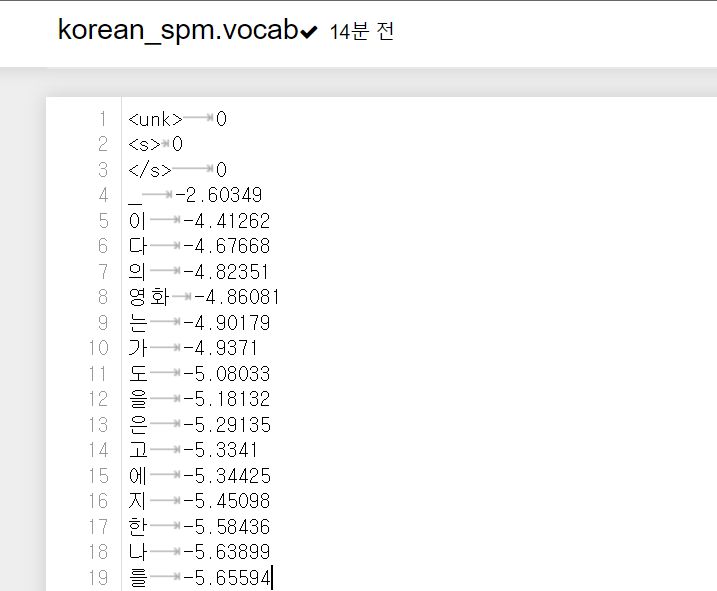

<br>

단어와 TAB 구분자, 그리고 인덱스가 보인다.

인덱스는 정수형 숫자가 아니다. 

다만 아래의 sp_tokenize 구현에서 enumerate를 통해 다시 정수 인덱스로 바꾸게 될 것이다.

#### ▪️ sentencepiece 단어 사전, Tensor 데이터

In [58]:
def sp_tokenize(spp, train_corpus, test_corpus, pad_seq="post", model_type="unigram"):

    ## vocab 단어사전
    with open("./spm_" + model_type +".vocab", "r") as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    
    ## Tensor
    train_tensor = []
    test_tensor = []

    for sen in train_corpus["document"]:
        train_tensor.append(spp.EncodeAsIds(sen))
    for sen in test_corpus["document"]:
        test_tensor.append(spp.EncodeAsIds(sen))

    ## Padding
    tensor = np.concatenate([train_tensor] + [test_tensor])
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding=pad_seq)
    train_tensor = tensor[:len(train_tensor)]
    test_tensor = tensor[len(train_tensor):]
    
    y_train = np.array(train_corpus["label"])
    y_test = np.array(test_corpus["label"])

    return (train_tensor, y_train, test_tensor, y_test), word_index, index_word

In [59]:
sp_tt_pack, sp_word2idx, sp_idx2word = sp_tokenize(spp_uni, train_data_sp, test_data_sp, pad_seq=pad_seq)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


텐서 데이터를 확인 해 보자.

In [60]:
sp_xtrain, sp_ytrain, sp_xtest, sp_ytest = sp_tt_pack

In [61]:
sp_xtrain[55]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          3, 3375,   74,  274, 1652,   15], dtype=int32)

In [62]:
sp_ytrain[55]

1

&nbsp;

### 3. 훈련과 평가

한가지 모델을 선정하여 훈련을 진행하도록 하겠다.

#### ◾모델 설계 및 컴파일

여기서는 LSTM 모델을 사용하도록 하겠다.

In [63]:
vocab_size = vocab_size    # 어휘 사전의 크기입니다
word_vector_dim = 16       # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

epochs = 8
batch_size = 128


In [64]:
LSTM_sp_uni_model = tf.keras.Sequential()
LSTM_sp_uni_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_sp_uni_model.add(tf.keras.layers.LSTM(128, dropout=0.5))
LSTM_sp_uni_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_sp_uni_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
LSTM_sp_uni_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               74240     
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 203,281
Trainable params: 203,281
Non-trainable params: 0
_________________________________________________________________


In [65]:
LSTM_sp_uni_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
# sp_xtrain, sp_ytrain, sp_xtest, sp_ytest

LSTM_sp_uni_hist = LSTM_sp_uni_model.fit(sp_xtrain, 
                                         sp_ytrain, 
                                         epochs=epochs, 
                                         batch_size=batch_size, 
                                         verbose=1)
LSTM_sp_uni_result = LSTM_sp_uni_model.evaluate(sp_xtest, sp_ytest, verbose=2)
print("─" * 64)
print(LSTM_sp_uni_result)
print("─" * 64)

Epoch 1/8
885/885 [==============================] - 11s 6ms/step - loss: 0.4468 - accuracy: 0.7827
Epoch 2/8
885/885 [==============================] - 5s 5ms/step - loss: 0.3510 - accuracy: 0.8473
Epoch 3/8
885/885 [==============================] - 5s 5ms/step - loss: 0.3357 - accuracy: 0.8541
Epoch 4/8
885/885 [==============================] - 5s 5ms/step - loss: 0.3257 - accuracy: 0.8584
Epoch 5/8
885/885 [==============================] - 5s 5ms/step - loss: 0.3168 - accuracy: 0.8617
Epoch 6/8
885/885 [==============================] - 4s 5ms/step - loss: 0.3086 - accuracy: 0.8642
Epoch 7/8
885/885 [==============================] - 5s 5ms/step - loss: 0.3016 - accuracy: 0.8677
Epoch 8/8
885/885 [==============================] - 5s 5ms/step - loss: 0.2957 - accuracy: 0.8713
1188/1188 - 3s - loss: 0.3392 - accuracy: 0.8508
────────────────────────────────────────────────────────────────
[0.3391886353492737, 0.850760817527771]
─────────────────────────────────────────────────────

#### ◾그래프 시각화

그래프를 시각화 하는 함수를 정의하겠다.

In [67]:
def hist_plot(history:tf.keras.callbacks.History()):

    tacc = history.history["accuracy"]
#     vacc = history.history["val_accuracy"]

    tloss=history.history["loss"]
#     vloss=history.history["val_loss"]

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, tacc, label="Training Accuracy")
#     plt.plot(epochs_range, vacc, label="Validation Accuracy")
    plt.legend(loc="lower right")
#     plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, tloss, label="Training Loss")
#     plt.plot(epochs_range, vloss, label="Validation Loss")
    plt.legend(loc="upper right")
#     plt.title("Training and Validation Loss")
    
    plt.show()

이 함수를 토대로 훈련 결과를 그래프로 그려보자.

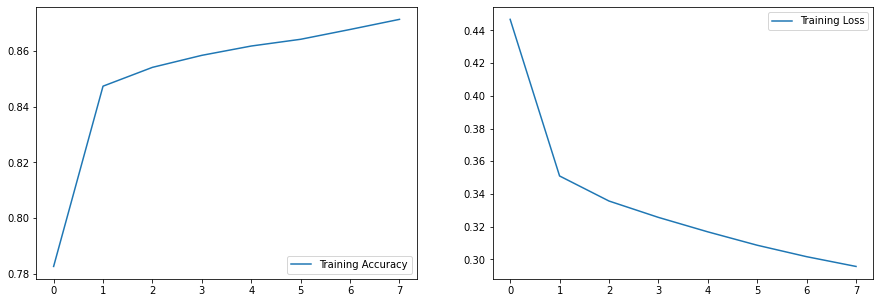

In [68]:
hist_plot(LSTM_sp_uni_hist)

<hr>

koNLPy 의 다른 모델들을 훈련시켜보고 성능을 확인해보자.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 203,281
Trainable params: 203,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
885/885 [==============================] - 8s 6ms/step - loss: 0.4377 - accuracy: 0.7914
Epoch 2/8
885/885 [==============================] - 5s 5ms/step - loss: 0.3652 - accuracy: 0.8405
Epoch 3/8
885/885 [=============================

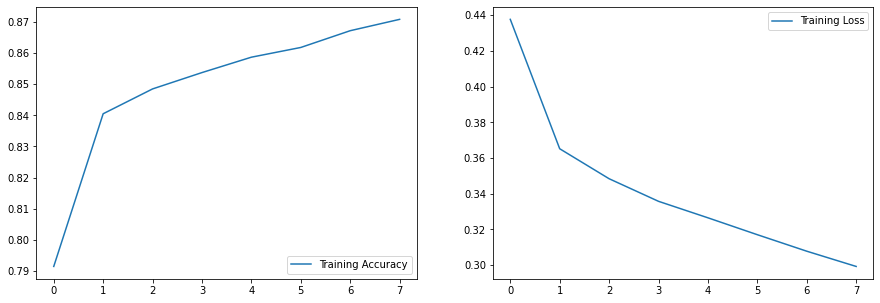

In [69]:
## Mecab Unpacking
mec_xtrain, mec_ytrain, mec_xtest, mec_ytest = mec_enc_pack

LSTM_mec_model = tf.keras.Sequential()
LSTM_mec_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_mec_model.add(tf.keras.layers.LSTM(128, dropout=0.5))
LSTM_mec_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_mec_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
LSTM_mec_model.summary()
LSTM_mec_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_mec_hist = LSTM_mec_model.fit(mec_xtrain,
                                   mec_ytrain, 
                                   epochs=epochs, 
                                   batch_size=batch_size, 
                                   verbose=1)
LSTM_mec_result = LSTM_mec_model.evaluate(mec_xtest, mec_ytest, verbose=2)
print("─" * 64)
print(LSTM_mec_result)
print("─" * 64)
hist_plot(LSTM_mec_hist)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          256000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 331,281
Trainable params: 331,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
885/885 [==============================] - 13s 6ms/step - loss: 0.4995 - accuracy: 0.7433
Epoch 2/8
885/885 [==============================] - 4s 5ms/step - loss: 0.4228 - accuracy: 0.7980
Epoch 3/8
885/885 [============================

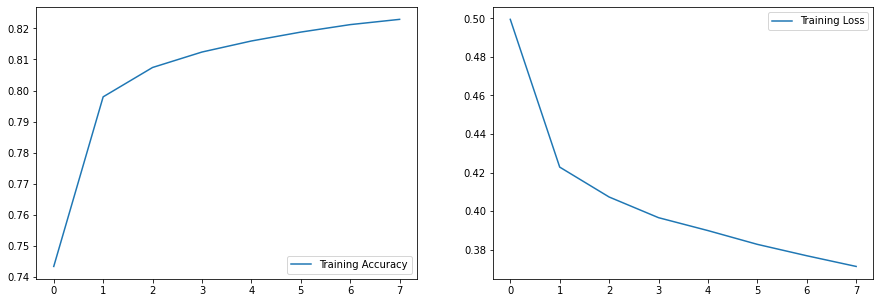

In [75]:
## Hannanum Unpacking
hnn_xtrain, hnn_ytrain, hnn_xtest, hnn_ytest = hnn_enc_pack

LSTM_hnn_model = tf.keras.Sequential()
LSTM_hnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_hnn_model.add(tf.keras.layers.LSTM(128, dropout=0.5))
LSTM_hnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_hnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
LSTM_hnn_model.summary()
LSTM_hnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_hnn_hist = LSTM_hnn_model.fit(hnn_xtrain,
                                   hnn_ytrain, 
                                   epochs=epochs, 
                                   batch_size=batch_size, 
                                   verbose=1)
LSTM_hnn_result = LSTM_hnn_model.evaluate(hnn_xtest, hnn_ytest, verbose=2)
print("─" * 64)
print(LSTM_hnn_result)
print("─" * 64)
hist_plot(LSTM_hnn_hist)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 203,281
Trainable params: 203,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
885/885 [==============================] - 7s 6ms/step - loss: 0.4586 - accuracy: 0.7768
Epoch 2/8
885/885 [==============================] - 4s 5ms/step - loss: 0.3841 - accuracy: 0.8287
Epoch 3/8
885/885 [=============================

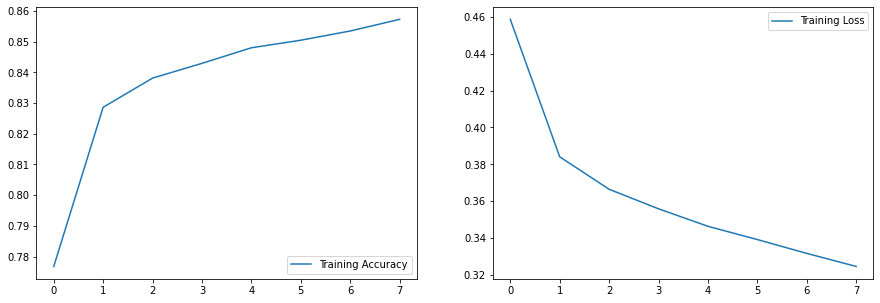

In [71]:
## Komoran Unpacking
kmr_xtrain, kmr_ytrain, kmr_xtest, kmr_ytest = kmr_enc_pack

LSTM_kmr_model = tf.keras.Sequential()
LSTM_kmr_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_kmr_model.add(tf.keras.layers.LSTM(128, dropout=0.5))
LSTM_kmr_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_kmr_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
LSTM_kmr_model.summary()
LSTM_kmr_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_kmr_hist = LSTM_kmr_model.fit(kmr_xtrain,
                                       kmr_ytrain, 
                                       epochs=epochs, 
                                       batch_size=batch_size, 
                                       verbose=1)
LSTM_kmr_result = LSTM_kmr_model.evaluate(kmr_xtest, kmr_ytest, verbose=2)
print("─" * 64)
print(LSTM_kmr_result)
print("─" * 64)
hist_plot(LSTM_kmr_hist)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 203,281
Trainable params: 203,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
885/885 [==============================] - 11s 6ms/step - loss: 0.4439 - accuracy: 0.7857
Epoch 2/8
885/885 [==============================] - 4s 5ms/step - loss: 0.3635 - accuracy: 0.8395
Epoch 3/8
885/885 [============================

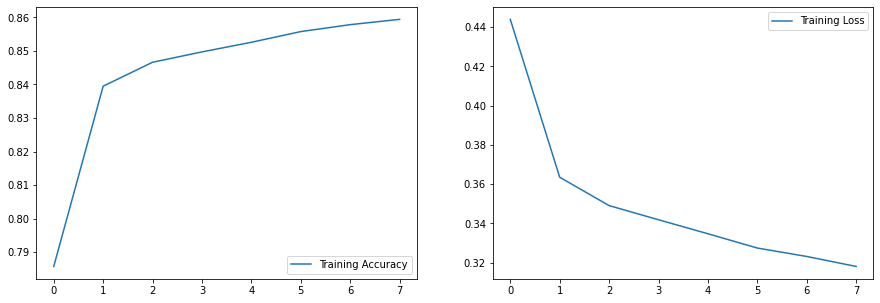

In [72]:
## Okt Unpacking
okt_xtrain, okt_ytrain, okt_xtest, okt_ytest = okt_enc_pack

LSTM_okt_model = tf.keras.Sequential()
LSTM_okt_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_okt_model.add(tf.keras.layers.LSTM(128, dropout=0.5))
LSTM_okt_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_okt_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
LSTM_okt_model.summary()
LSTM_okt_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_okt_hist = LSTM_okt_model.fit(okt_xtrain,
                                       okt_ytrain, 
                                       epochs=epochs, 
                                       batch_size=batch_size, 
                                       verbose=1)
LSTM_okt_result = LSTM_okt_model.evaluate(okt_xtest, okt_ytest, verbose=2)
print("─" * 64)
print(LSTM_okt_result)
print("─" * 64)
hist_plot(LSTM_okt_hist)

<hr>

#### ▪️ SentencePiece 모델 성능 개선 여부 확인

기존 모델 대비 vocab_size 를 더 키운 모델은 과연 성능 개선에 영향을 주는지 확인해보자.

In [73]:
vocab_size = 32000
model_type = "unigram"

spm_uni2 = spm_train(train_data_sp["document"], test_data_sp["document"], vocab_size=vocab_size, model_type=model_type)
spp_uni2 = spm.SentencePieceProcessor()
spp_uni2.Load("spm_" + model_type + ".model")
spu2_tt_pack, spu2_word2idx, spu2_idx2word = sp_tokenize(spp_uni2, train_data_sp, test_data_sp, model_type=model_type)

## sentencepiece unpacking
spu2_xtrain, spu2_ytrain, spu2_xtest, spu2_ytest = spu2_tt_pack

[1／3]


100%|██████████| 113255/113255 [00:00<00:00, 1313024.21it/s]


────────────────────────────────────────────────────────────────
[2／3]


100%|██████████| 37986/37986 [00:00<00:00, 1210638.22it/s]

────────────────────────────────────────────────────────────────



sentencepiece_trainer.cc(177) LOG(

[3／3] SentencePieceTrainer.Train() Start
SentencePieceTrainer.Train() End
────────────────────────────────────────────────────────────────


INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/nsmc_sp_unigram.train.ko.temp --model_prefix=spm_unigram --vocab_size=16000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/nsmc_sp_unigram.train.ko.temp
  input_format: 
  model_prefix: spm_unigram
  model_type: UNIGRAM
  vocab_size: 16000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          256000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 331,281
Trainable params: 331,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
885/885 [==============================] - 11s 6ms/step - loss: 0.6932 - accuracy: 0.4992
Epoch 2/8
885/885 [==============================] - 5s 5ms/step - loss: 0.6932 - accuracy: 0.4995
Epoch 3/8
885/885 [============================

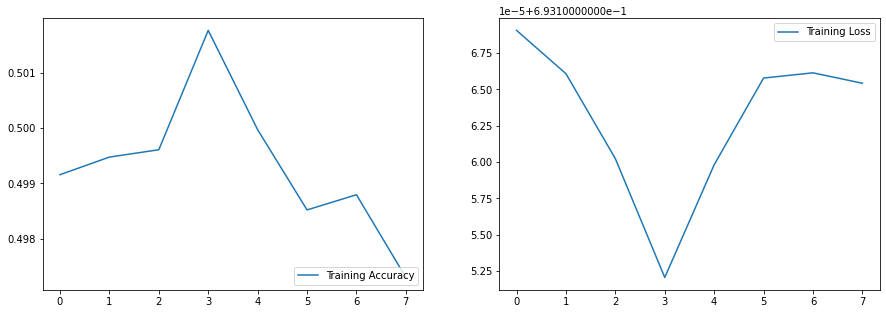

In [74]:
LSTM_sp_uni2_model = tf.keras.Sequential()
LSTM_sp_uni2_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_sp_uni2_model.add(tf.keras.layers.LSTM(128, dropout=0.5))
LSTM_sp_uni2_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_sp_uni2_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
LSTM_sp_uni2_model.summary()
LSTM_sp_uni2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_sp_uni2_hist = LSTM_sp_uni2_model.fit(spu2_xtrain,
                                           spu2_ytrain, 
                                           epochs=epochs, 
                                           batch_size=batch_size, 
                                           verbose=1)
LSTM_sp_uni2_result = LSTM_sp_uni2_model.evaluate(spu2_xtest, spu2_ytest, verbose=2)
print("─" * 64)
print(LSTM_sp_uni2_result)
print("─" * 64)
hist_plot(LSTM_sp_uni2_hist)

문제가 없을것이라고 생각했는데 오히려 성능이 많이 떨어진 모습을 보인다.

버그가 있거나 아니면 실제로 설명과 달리 Vocab_size 를 늘리는 것으로 성능개선을 기대 할 수 없는 것인지,

spm 을 다시 사용하면 안되는 것인지, 어딘가에서 문제가 있는것 같다.

성능개선 여부를 반대로 설정하여 (기본 SentencePiece 모델을 나중에, vocab_size 늘린 모델을 먼저 실행)

실행을 해 본 결과 84％ 이상 정확도를 확인했었고, 역시나 나중에 실행한 모델은 50％ 대로 떨어졌다.

지금은 다시 순서를 원래대로 돌려놓았다. 처음 실행 외에 새로 SentencePiece 모델을 훈련시킬 경우에는 성능이 대폭 저하되었다.

기본 모델을 후순위로 미루거나 하였을때 처럼, 독립된 환경에서 처음 실행하는 경우에만 정상적인 결과를 확인할 수 있었다.

변수 겹침등은 없는데, spm 을 static 변수처럼 사용하는 부분에서 문제가 발생하는 것 같다.

정상적으로 실행 됐을때의 결과는 아래와 같다. (캡쳐해둔 이미지 파일 첨부)

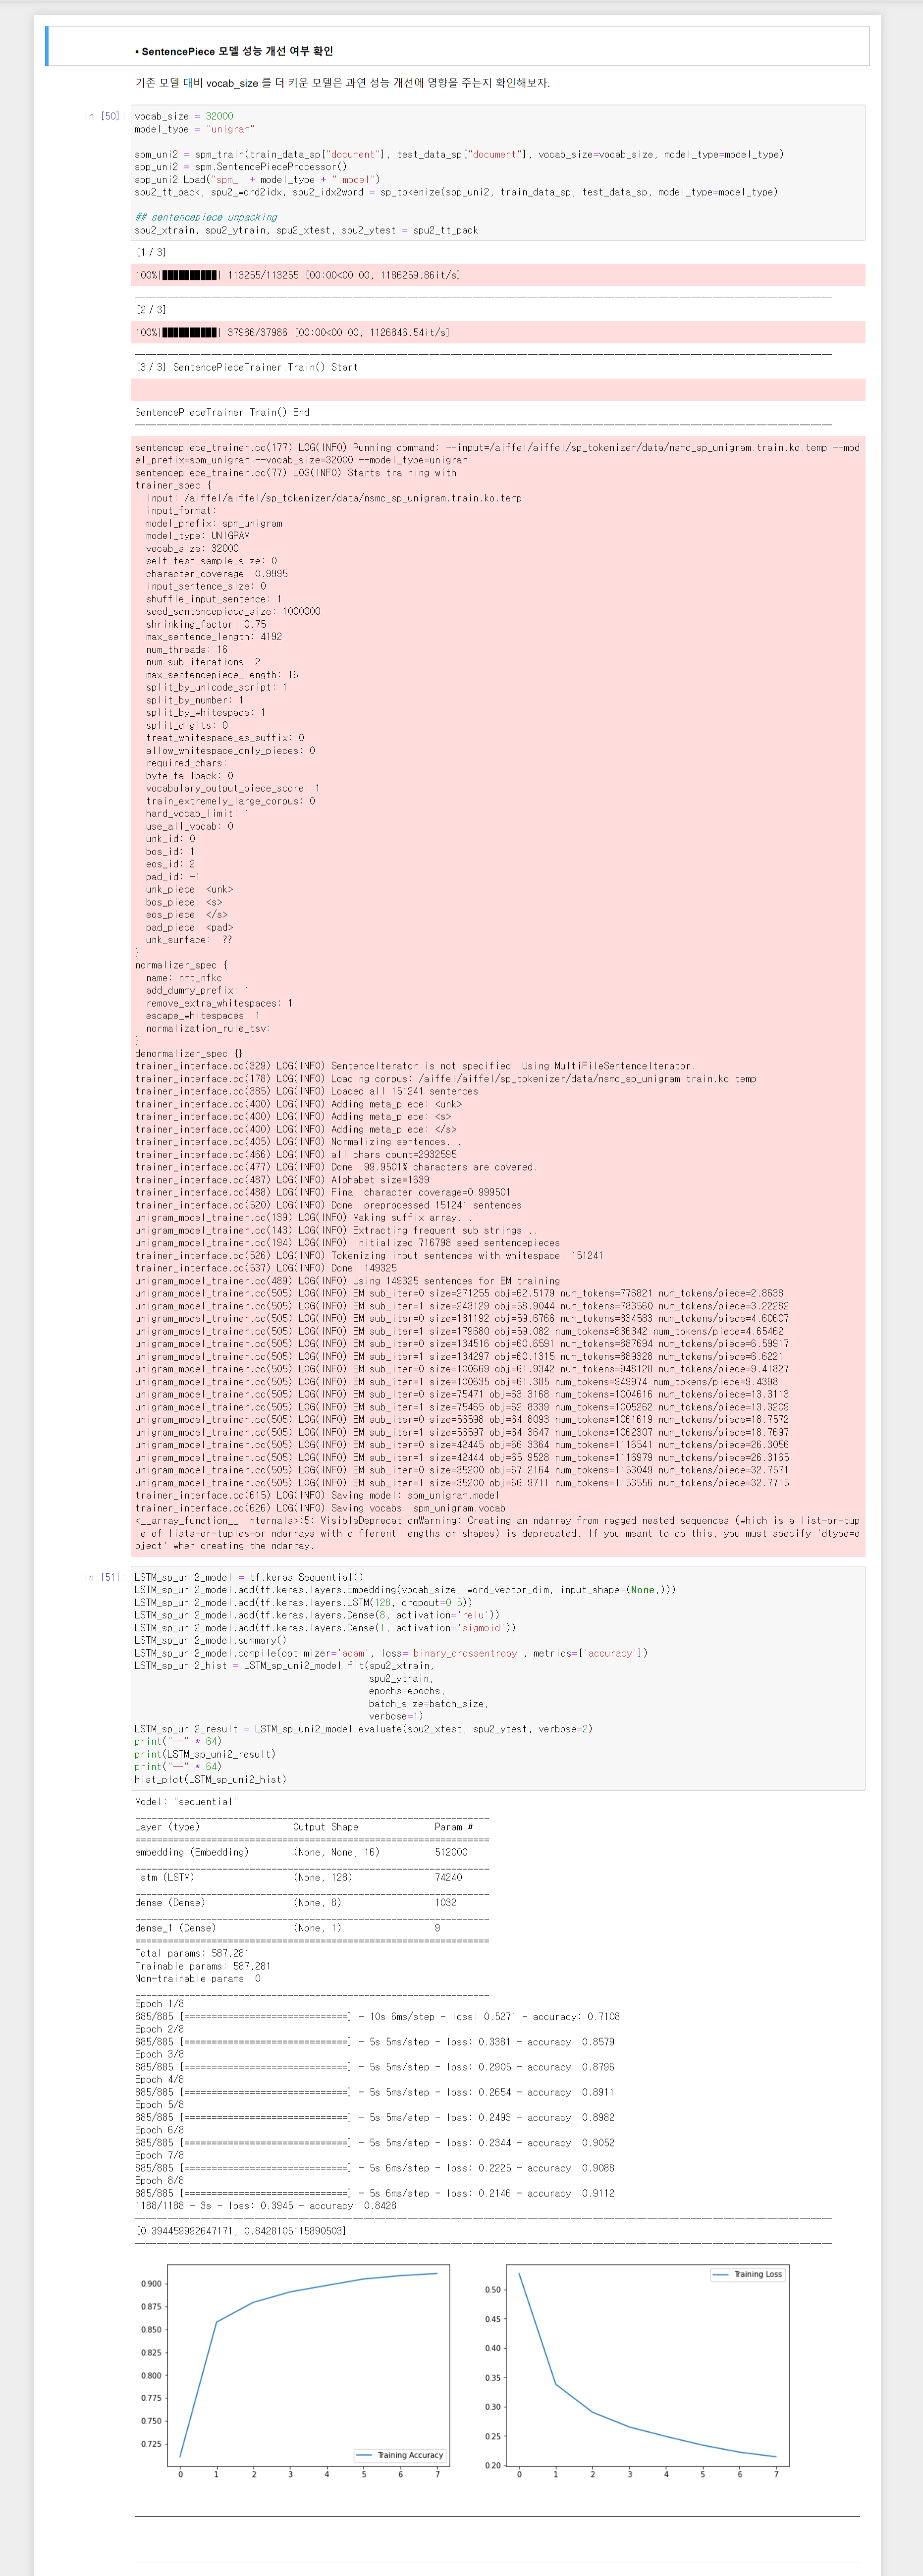

기존대비 vocab_size 를 8000 → 32000 으로 바꾸어 보았다.

훈련 반복을 더 해봤으면 모르겠지만, 다른 것들도 모두 반복횟수를 동일하게 맞춘 조건이라,

성능 개선 여부에 대해서는 당장의 수치만으로 뚜렷한 개선을 확인하기 어려웠다.

&nbsp;

세번째 SentencePiece 모델을 다시 만들어 보도록 하자.

이번에는 unigram 이 아니라 bpe 타입의 모델을 만들도록 하겠다.

이전에 정의해 둔 함수에 매개변수를 전달하면 바로 사용할 수 있다.

다만, bpe 의 경우, 시간이 지나도 진행이 안되는 것 같았다.

마지막으로 그냥 밤새 돌려보도록 하겠다.

In [75]:
# vocab_size=32000
# model_type="bpe"

In [ ]:
# %%time
# spm_bpe = spm_train(train_data_sp["document"], test_data_sp["document"], vocab_size=vocab_size, model_type=model_type)

[1／3]


100%|██████████| 113255/113255 [00:00<00:00, 1284930.35it/s]


────────────────────────────────────────────────────────────────
[2／3]


100%|██████████| 37986/37986 [00:00<00:00, 1185602.58it/s]

In [ ]:
# %%time
# spp_bpe = spm.SentencePieceProcessor()

In [ ]:
# %%time
# spp_bpe.Load("spm_" + model_type + ".model")

In [ ]:
# %%time
# spb_tt_pack, spb_word2idx, spb_idx2word = sp_tokenize(spp_bpe, train_data_sp, test_data_sp, model_type=model_type)

In [ ]:
# %%time
# ## sentencepiece unpacking
# spb_xtrain, spb_ytrain, spb_xtest, spb_ytest = spb_tt_pack

동일한 LSTM 모델 설계하여 훈련시킨다.

In [ ]:
# LSTM_sp_bpe_model = tf.keras.Sequential()
# LSTM_sp_bpe_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# LSTM_sp_bpe_model.add(tf.keras.layers.LSTM(128, dropout=0.5))
# LSTM_sp_bpe_model.add(tf.keras.layers.Dense(8, activation='relu'))
# LSTM_sp_bpe_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
# LSTM_sp_bpe_model.summary()
# LSTM_sp_bpe_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# LSTM_sp_bpe_hist = LSTM_sp_bpe_model.fit(spb_xtrain, 
#                                          spb_ytrain, 
#                                          epochs=epochs, 
#                                          batch_size=batch_size, 
#                                          verbose=1)
# LSTM_sp_unit2_result = LSTM_sp_uni2_model.evaluate(spb_xtest, spb_ytest, verbose=2)
# print("─" * 64)
# print(LSTM_sp_unit2_result)
# print("─" * 64)
# hist_plot(LSTM_okt_hist)

In [ ]:
# hist_plot(LSTM_sp_bpe_hist)

6시간 이상 확인해 본 결과, 진행이 안되는것 같다.

SentencePiece 의 model_type=bpe 의 경우는 실행환경의 문제인지, 도무지 진행이 안된다.

단독으로 실행해도 진행이 안되는데, 멈춘것 같지도 않으면서 아무런 응답이 없으니 이유를 모르겠다.

프로젝트 수행과제에 해당하는 실험들은 다 해보았으나, 여러 해결 못한 문제들로 인해 결과가 만족스럽지 않다.

현재 상황은 프로젝트 프리뷰의 수행과제 목록과 루브릭 요소들 위주로 최소한의 수행 해 본 수준이지만,

실험은 이정도에서 마무리 해야 할 것 같다.

&nbsp;

### 4. 실험 결과 분석

실험에 앞서, 모델은 아래의 LSTM 모델을 내용을 파라메터와 동일하게 사용하였다. (단, 「SentencePiece 비교」 Tokenizer는 제외.)

~~~ python

    ## vocab_size = 8000
    ## word_vector_dim = 16
    ## epochs = 8
    ## batch_size = 128
    ## tf.keras.layers.Embedding(input_dim, output_dim, input_shape=(None,)))

    LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    LSTM_model.add(tf.keras.layers.LSTM(128, dropout=0.5))
    LSTM_model.add(tf.keras.layers.Dense(8, activation='relu'))
    LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

~~~

동일한 조건으로 실험을 하였고, 결과는 위에서 블록마다 그래프와 함께 표기해 두었다.

아래에서는, 동일한 내용을 한번에 볼 수 있게 간단히 표로 정리 하였다. 수치는 소수점 4번째 자리부터 버림 하였다.

|Tokenizer|train_loss|train_accuracy|test_loss|test_accuracy|
|:-------:|:--------:|:------------:|:-------:|:-----------:|
|SentencePiece 기본|0.296|0.871|0.339|0.850|
|SentencePiece 비교|0.214|0.911|0.394|0.842|
|KoNLPy - Hannanum|0.371|0.822|0.416|0.802|
|KoNLPy - Komoran|0.324|0.857|0.365|0.836|
|KoNLPy - Mecab|0.299|0.870|0.341|0.849|
|KoNLPy - Okt|0.318|0.859|0.367|0.835|

결과에서 볼 수 있듯이, SentencePiece 토크나이저가 가장 우수한 성능을 보였다.

KoNLPy 의 Mecab 토크나이저도 좋은 성능을 보여주었다.

제한된 실험의 결과로 SentencePiece 토크나이저의 모델들이 모두 성능이 좋은 편으로 나오긴 하였으나,

다른 토크나이저의 모델들을 압도하거나, 뚜렷하게 더 나은 성능을 보여주지는 못했다고 생각된다.

하지만 가능성과 기본 성능 자체가 워낙 좋은편이라, 

결론적으로는 KoNLPy 보다 우수하다고 할 수 있겠다. KoNLPy 에서는 Mecab 이 그나마 선방한 것 같다.

또한 성능 개선을 비교해 보기 위한 SentencePiece 비교 토크나이저의 경우,

훈련스텝에서 accuracy 가 91％에 도달하는 모습을 보여주었는데,

훈련 반복횟수를 8회로 동일하게 고정하다보니, 84.2％ 정도에서 훈련을 마쳤지만,

각 epochs 당 수치 변화나 그래프를 보았을 때, 잠재력이 분명 더 있을 것 같다는 생각이 들었다.

더 많은 실험을 통해 정확도를 끌어 올릴 수 있다고 생각하지만, 실험을 많이 수행하지 못한 점이 아쉽다.

<hr>

## ■ 프로젝트 회고

#### 1) 이번 프로젝트에서 '어려웠던 점'

여러가지 문제들로 인해 이것저것 실험을 해 볼 수가 없었다.

수행해 볼 법한 부분들은 다 수행하고 확인하는 정도에서 그친 것 같다.

기본적으로 노드 학습/실습 부분에 나온 내용들과, 수행과제, 루브릭 등은 최소한도로 진행을 마쳐서 기본 틀을 잡고

시간 여유가 있을 것 같아서, 나머지 정리하면서 이것저것 다양한 실험을 해 보려고 계획 했었다.

그러나, 예상한 결과와 너무 떨어지는 결과가 나오는 것 부터, 알 수 없는 오류가 발생한다거나 하는 등의 트러블을 겪었다.

단독으로 사용하여 실험을 수행하기도 하였으나, 대부분의 실험을 그렇게 진행하기도 어려웠고

내용을 다 스크린샷으로 채우는것도 썩 좋은 방법 같지는 않다고 생각했다.

내가 작성해놓은 코드 블럭들의 배치라던가, 안정성등에 대한 신뢰가 가지를 않아서

지금 상황에서는 더 다양한 실험을 진행하는것은 어렵겠다는 생각이 들었다.

구성을 좀 다듬어야 하는데, 시간을 너무 많이 낭비한 것 때문에 어려움이 많을 것이라 생각하여,

기본적인 내용 전부 수행한 정도에서 정리하고 마무리 하는 쪽으로 방향을 돌려잡았다.

#### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

노드 학습 부분에서 전반적으로 토큰화, 사전만들기 등 자연어 처리에서 초반부에 처리하는 내용들을 학습하였다.

학습한 내용을 바탕으로, 프로젝트 진행하는 과정 대부분에서 여러가지 토큰화 방법들을 실습해 보는 내용이었다.

토큰화 과정 전에 수행되어야 하는 전처리나, 토큰화 이후에도 훈련을 통해 각 방법들을 비교 분석 해보았다.

SentencePiece 에 대해서 알아보는 과정에서 여러가지 장점과 특징에 대해서 알 수 있었다.

정상적으로 동작을 마치고 결과를 확인하지는 못했지만, SentencePiece 에 대해서도 여러가지 방법으로 접근 해보았다.

BPE 알고리즘이나 WPM 등의 Subword Segmentation 등에 대해서도 공부하였다.

다만 이 부분들은 아직 모르는 부분들이 많고. 내가 틀리게 알고 있는 부분들이 많이 보여서, 재학습이 필요한 것 같다.

#### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

SentencePiece 에서 vocab size 조정을 통해 성능의 변화를 어느정도 확인 할 수 있을 것이라고 생각했는데,

생각보다 차이가 많이 나지 않았다. 8000 에서 32000 정도로 약 4배의 크기로 조정하였으나

32000 모델이 0.3％ 가량의 수치로 조금 모자란 정도였다.

일반적으로 단어사전의 경우 어느정도 차이를 보일 것이라고 생각해서

혹시나 하는 마음에 16000 값도 테스트 해 보았으나, 32000 모델과 큰 차이가 없었다.

처음 접근을 10000 으로 할 때와 비교해서 큰 차이를 못느껴서, 줄여볼까도 생각은 했지만

KoNLPy 의 다른 모델들과의 비교 실험데이터를 남기기에는, SentencePiece 훈련 결과 문제 때문에 더 많은 실험을 하지 않았다.

여유가된다면 그 부분도 확인을 해서 정리를 하면 좋겠다고 생각하고 있다.

#### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

프로젝트의 기본적인 마무리 단계 까지 수행하면, 루브릭 평가지표는 전부 달성이 가능하다.

SentencePiece 의 다른 옵션의 경우 문제가 있었지만, 순서를 바꾸거나, 단독 실행해보고 값을 확인했다.

SentencePiece 통해서 결과 확인했으면 첫번째 두번째 루브릭을 수행한 것이 될 것이다.

이 프로젝에서 다룬 방법들은 모두 80％ 이상의 test accuracy 달성엔 어려움이 없는 것 같다. (evaluate 로 확인)

80％ 의 경우는, 예전 Exploration Project 08 에서도 어렵지 않게 달성했던 수준이며,

그때는 달성기준이 85％ 였다. 물론 지금 SentencePiece의 그것도 85％ 를 넘기긴 한다.

KoNLPy 의 다른 토크나이저들을 통해 SentencePiece 토크나이저를 사용했을때와의 성능 비교 분석하면 세번째 로브릭도 수행이다.

여기서는 그것들을 최소한으로 실습해보는 상태에서 머물렀다, 그래서 그 외 다른 실험은 수행하지 않았다.

#### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

루브릭 평가 지표 3개 문항 모두 커트라인이 낮은 편에 속한다고 생각한다.

잘 안돌아가는 다른 문제 때문에 시간이 없어서 완성을 못했다거나 한다면 달성하기 어렵다고 생각한다.

처리 해줘야 할 일들도 많고, 노드 학습/실습 부분에서의 예시를 바로 그대로 붙여넣어 사용하는 방법이

거의 안먹히기 시작하는것이, 실제로도 어렵지만, 더 어렵게 느껴질 수 있는 것에 한 몫 할 것 같다.

#### 6) 자기 다짐

프로젝트 진행하는 도중에, 자연어 처리 과정을 처음부터 다시 공부하는 듯한 느낌이 많이 들었다.

그런데, 얼마전에 했던것들도 기억이 잘 안나고 어디서부터 어떻게 해야할지 생각이 잘 안났다.

프로젝트 진행하는 과정에서도 예상치 못한 트러블이 많아서, 당황하기도 했다. 계획을 잘 못 세워서 시간 낭비도 했고.

최근 프로젝트하면서 그다지 트러블을 겪지 않았던 최근이 오히려 평소랑 달랐던 것 같다.

그래, 트러블이 있어야 프로젝트지… 이게 보통이지…

이번에 특히 우리말 토큰화를 여러가지 방법으로 실습 해 봤던 것들로 앞으로 자연어처리에서 우리말을 사용할 때 도움이 될 거 같다.

SentencePiece 에 대해서 여러 특징들을 알아보는 과정에서 속도도 정말 빠르고 메모리도 절약하는 데다가

텍스트 파일에서 모델 학습을 진행하는 점도 특이하다고 생각했다.

좀 더 시간 여유가 있다면 문제점들도 해결하고 여러가지 테스트도 해 보고 싶은데, 내 능력 부족으로 이정도에서 마무리 한 점이 아쉽다.

당분간은 한글 토크나이저 사용에서 koNLPy 쪽 보다는 SentencePiece 를 우선적으로 사용해 보면서 더 공부해 볼 생각이다.

koNLPy 도 그렇게 환경설정이나 안정성 측면에서 뚜렷하게 장점이 있다고 볼 수 없기 때문이다.

이런 점들이 장단점이 있다면, 

속도 빠르고, 정확도 측정결과 미미하게나마 더 높은 SentencePiece 를 우선적으로 고려해 보는것이 좋겠다고 생각한다.

다만, 내 기준으로, 완전히 갈아타기에는 나에게 시간과 경험이 더 필요할 것 같다.

어쨌든, 앞으로 계획대로 진행을 잘 해서 제대로 된 실험을 많이 수행하여 결과를 남기면 좋겠다.

아쉬움이 많이 남는다. 그리고 너무 많은 내용을 까먹어서 다시 공부를 해야 할 것 같다. 

마무리 하려니 공허함이 몰려온다. 

마지막으로 프로젝트 코드 작성중에 도움을 주신 장문규, 방승욱 그루님께 감사하다는 말씀을 남기며 마치겠다.

<hr>

◎ Reference


- (AIFFEL) Exploration Project Node 06. 작사가 인공지능 만들기


- (AIFFEL) Exploration Project Node 08. 영화리뷰 텍스트 감성분석하기


- (AIFFEL) Going Deeper Node 01. 텍스트 데이터 다루기


- (AIFFEL) Going Deeper Node 02. 멋진 단어사전 만들기


- (SentencePiece) [GitHub - SentencePiece](https://github.com/google/sentencepiece)


- (NLP) [자연어 처리의 4가지 단계](https://blog.diyaml.com/teampost/%EC%9E%90%EC%97%B0%EC%96%B4-%EC%B2%98%EB%A6%AC%EC%9D%98-4%EA%B0%80%EC%A7%80-%EB%8B%A8%EA%B3%84/#nlp-steps)


- (Subword) [자연어처리를 위한 BPE & SentencePiece](http://tensorboy.com/bpe-sentencepiece)


- (SentencePiece) [Sentencepiece python module example](https://github.com/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb)


- (SentencePiece) [Understanding SentencePiece](https://jacky2wong.medium.com/understanding-sentencepiece-under-standing-sentence-piece-ac8da59f6b08)


- (Subword) [Subword Tokenizer (BPE, SentencePiece, Wordpiece Model)](https://data-make.tistory.com/692)

<hr>